In [1]:
import os
import datetime
import math
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
    
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error



In [2]:
# DATA
df1 = pd.read_csv('data_day.csv')
df2 = pd.read_csv('data_2018-08-05_2021-04-30.csv')
df3 = pd.read_csv('data_2018-05-05_2018-08-04.csv')
df4 = pd.read_csv('data_2015-08-09_2018-05-04.csv')
df5 = pd.read_csv('data_2013-02-12_2015-08-08.csv')
df6 = pd.read_csv('data_2010-05-19_to_2013-02-11.csv')
df7 = pd.read_csv('data_2007-08-23_to_2010-05-18.csv')
df8 = pd.read_csv('data_2004-11-26_to_2007-08-22.csv')
df = pd.concat([df6, df5, df4, df3, df2, df1])
df.index = range(0,4996)
df.tail()

date_time = pd.concat([pd.to_datetime(df['datetime'][0:4000]),pd.to_datetime(df['datetime'][4000:])])
data_use = df[['temp','tempmax', 'tempmin','humidity', 'precip', 'windspeed', 'solarradiation', 'solarenergy']]
print(data_use)

      temp  tempmax  tempmin  humidity  precip  windspeed  solarradiation  \
0     30.8     36.5     26.0      78.1   0.000       20.5           301.4   
1     31.3     36.4     27.0      76.0   0.300       24.1           281.5   
2     30.7     39.0     26.0      76.1   2.300       40.7           237.1   
3     31.5     39.6     26.0      71.2   0.800       15.1           296.8   
4     27.6     30.8     25.8      80.1  33.000       22.7           240.8   
...    ...      ...      ...       ...     ...        ...             ...   
4991  20.5     22.0     19.5      93.8   8.794       17.5           148.7   
4992  22.4     26.5     20.0      84.5   0.683       19.4           140.8   
4993  22.6     26.6     20.0      85.5   0.072       20.3           131.9   
4994  23.0     26.0     19.0      82.4   3.300       20.5            63.7   
4995  16.0     18.0     14.0      91.4   3.400       22.3            15.8   

      solarenergy  
0            26.1  
1            24.3  
2            20

In [3]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
timestamp_s[1] - timestamp_s[0]

86400.0

C:\Users\tridu\AppData\Local\Temp\ipykernel_23296\1206436225.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_use['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
C:\Users\tridu\AppData\Local\Temp\ipykernel_23296\1206436225.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_use['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


Index(['temp', 'tempmax', 'tempmin', 'humidity', 'precip', 'windspeed',
       'solarradiation', 'solarenergy', 'Year sin', 'Year cos'],
      dtype='object')

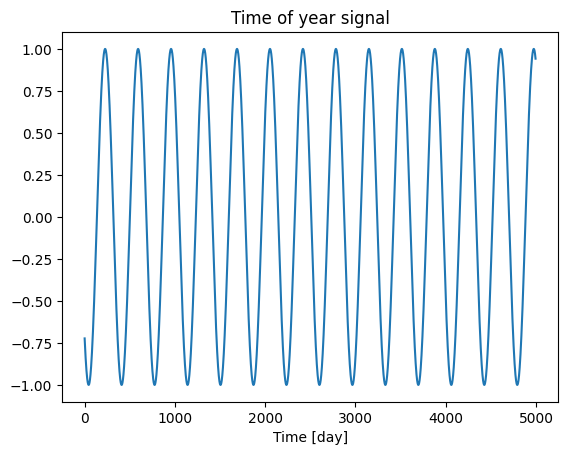

In [4]:
# PERIOD TIME

day = 24*60*60
year = (365.2425)*day
# df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
# df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
data_use['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
data_use['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

# plt.plot(np.array(df['Year sin'])[:366])
plt.plot(np.array(data_use['Year cos'])[:])
plt.xlabel('Time [day]')
plt.title('Time of year signal')
data_use.columns

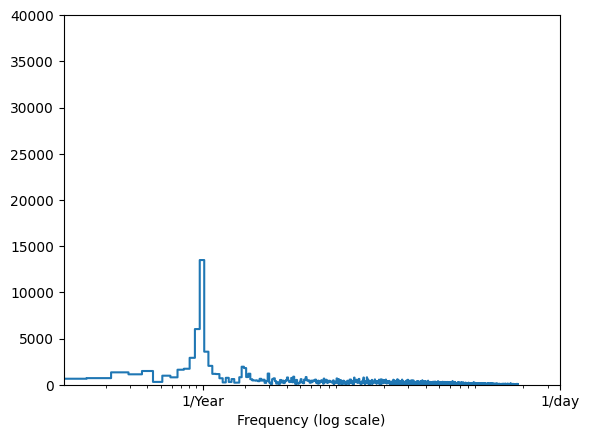

In [5]:
fft = tf.signal.rfft(data_use['temp'])
f_per_dataset = np.arange(0, len(fft))

n_samples_day = len(data_use['humidity'])
days_per_year = 365.2524
years_per_dataset = n_samples_day/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 40000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [6]:
number_train = int(data_use.shape[0] * 0.8)
train, test = data_use[0:number_train], data_use[number_train:]

In [8]:
def create_data(in_steps, out_steps, data, features):
    X = []
    y = []
    for i in range(len(data)-in_steps-out_steps):
        X.append(data[i:i+in_steps])
        y.append(data[i+in_steps:i+in_steps+out_steps][features])
    return np.array(X), np.array(y)
def normalize(data, train_mean, train_std):
    data_norm = (data - train_mean)/train_std
    return data_norm
def unnormalize(data, train_mean, train_std):
    data_unnorm = (data * train_std) + train_mean
    return data_unnorm


In [24]:
in_steps = 60
out_steps = 7
features_train = ['temp']
num_features = len(features_train) 

In [25]:
X_train, y_train = create_data(in_steps, out_steps, train, features_train)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], num_features)

X_test, y_test = create_data(in_steps, out_steps, test, ['temp'])
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], num_features)

X_train_norm = normalize(X_train, X_train.mean(), X_train.std())
y_train_norm = normalize(y_train, y_train.mean(), y_train.std())

X_test_norm = normalize(X_test, X_train.mean(), X_train.std())
y_test_norm = normalize(y_test, y_train.mean(), y_train.std())

print(X_train_norm.shape, y_train_norm.shape, X_test_norm.shape, y_test_norm.shape)


(3929, 60, 10) (3929, 7, 1) (933, 60, 10) (933, 7, 1)


In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(out_steps*2),
    tf.keras.layers.Reshape([out_steps, 2])
])



In [34]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Lion(learning_rate = 0.001),
)

In [35]:
history = model.fit(X_train_norm, y_train_norm, epochs=10, validation_split=0.2, batch_size=32, validation_batch_size=32)

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.7419 - val_loss: 0.4265
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.2726 - val_loss: 0.3884
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.2464 - val_loss: 0.2780
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.2283 - val_loss: 0.2345
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.2156 - val_loss: 0.2482
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.2018 - val_loss: 0.2426
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1920 - val_loss: 0.2462
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1922 - val_loss: 0.2766
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1767 - val_loss: 0.2881
Epoch 10/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1731 - val_loss: 0.3123


In [36]:
model.save('lstm60-7-temp-not_overfit.keras')

In [37]:
model_recall = tf.keras.models.load_model('lstm60-7-temp-not_overfit.keras')

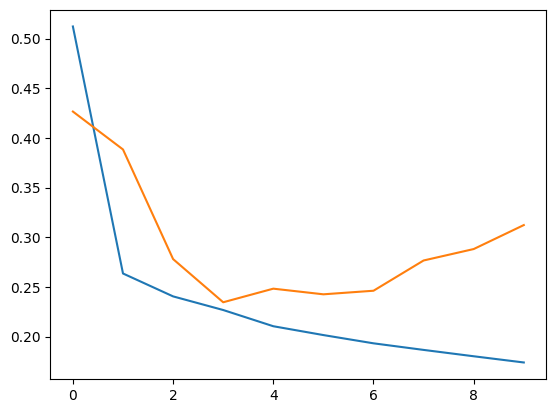

In [38]:
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])

In [39]:
print(model_recall.evaluate(X_test_norm, y_test_norm))
print(model.evaluate(X_test_norm, y_test_norm))

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2361
0.23148062825202942
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2361
0.23148062825202942


In [40]:
predict = model_recall.predict(X_test_norm)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Day:  1
MAE:  1.3447216729003646
MSE:  2.9605512414721624
CORR:  0.9435586051666357
Day:  2
MAE:  1.7656368791226533
MSE:  5.108528977183027
CORR:  0.8981228750594817
Day:  3
MAE:  1.9738337667042039
MSE:  6.533483648363646
CORR:  0.8665408823377153
Day:  4
MAE:  2.0870691105228274
MSE:  7.1686466440596
CORR:  0.8525314422704703
Day:  5
MAE:  2.1467349008476364
MSE:  7.56707733057171
CORR:  0.8437218437736818
Day:  6
MAE:  2.2277634746392057
MSE:  8.089322028419803
CORR:  0.8321194345222601
Day:  7
MAE:  2.2057055102283933
MSE:  8.073143098839049
CORR:  0.8336530353287102


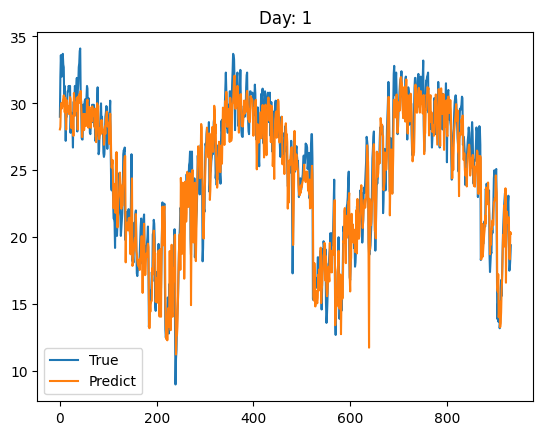

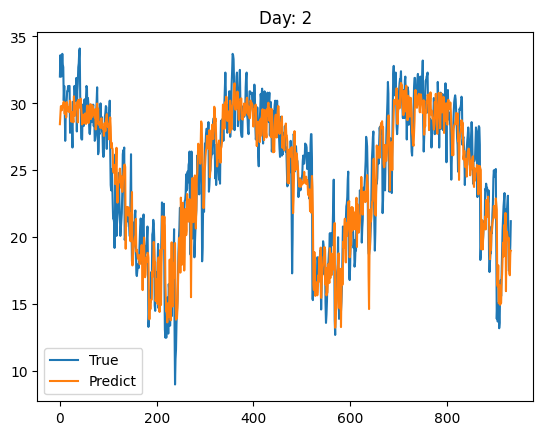

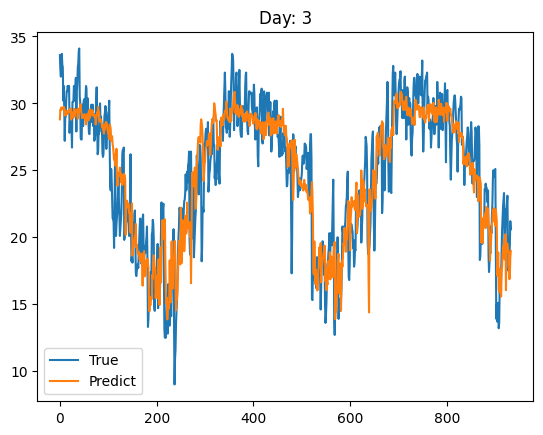

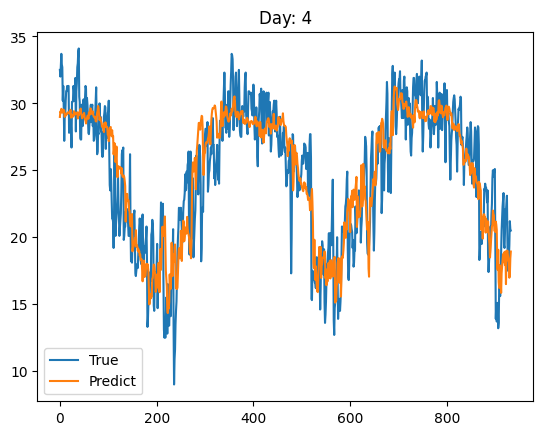

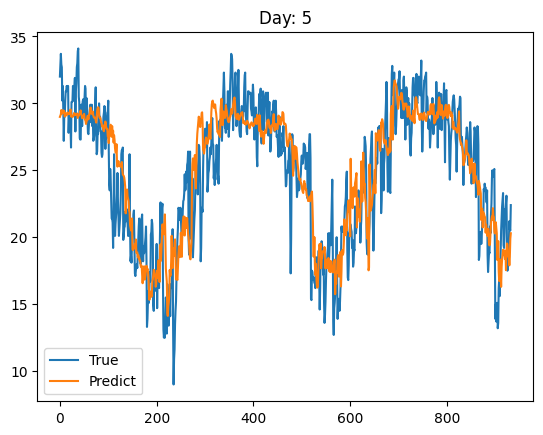

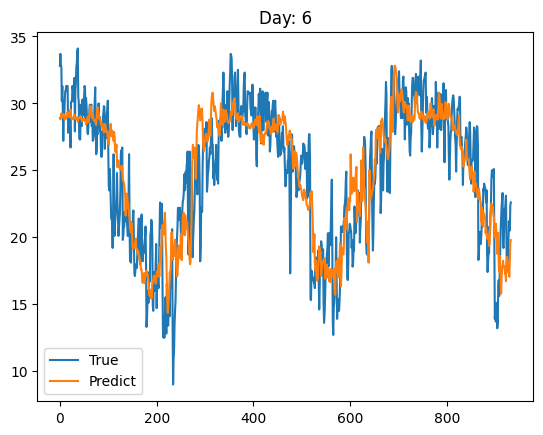

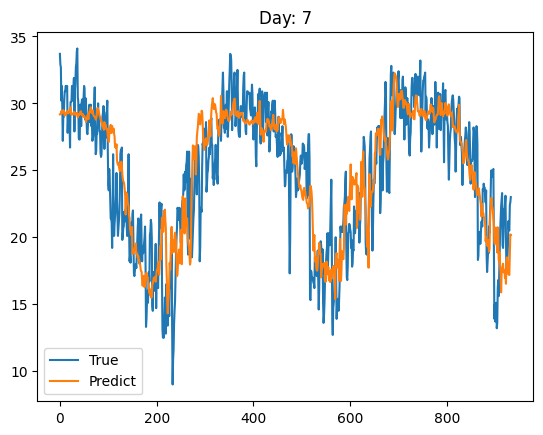

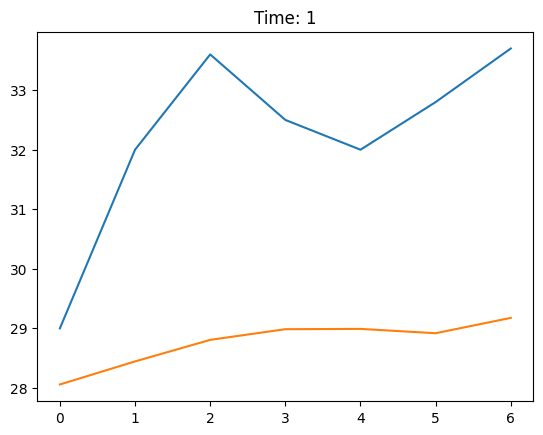

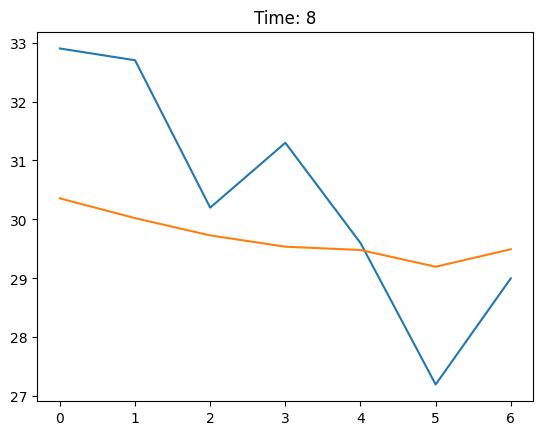

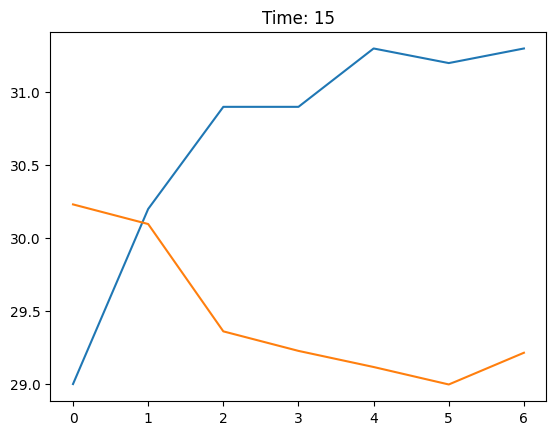

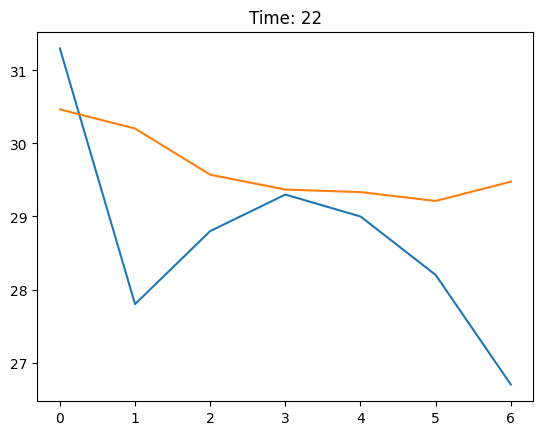

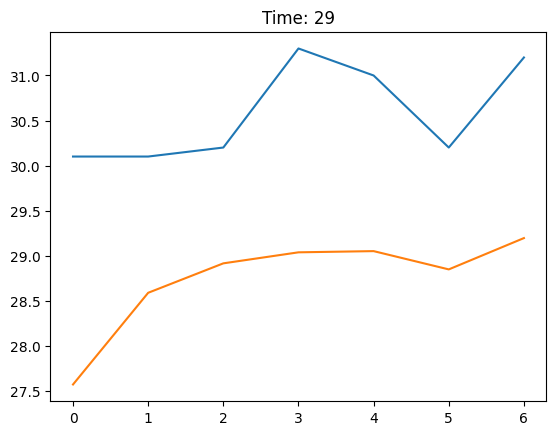

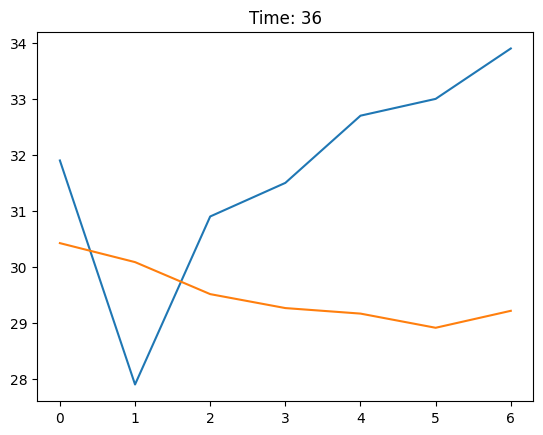

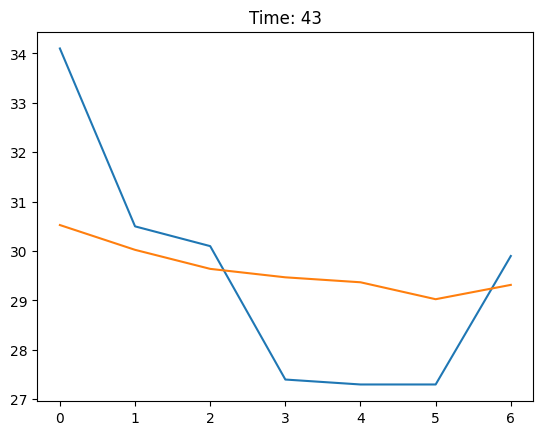

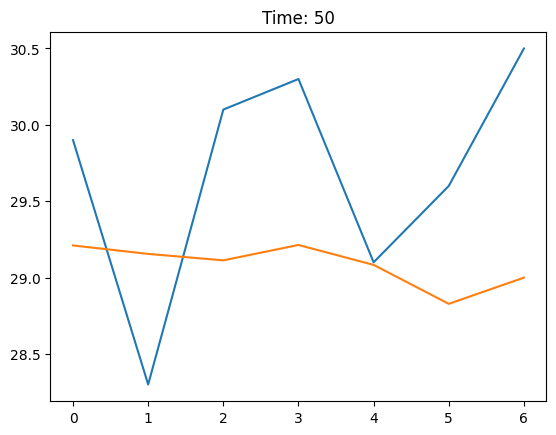

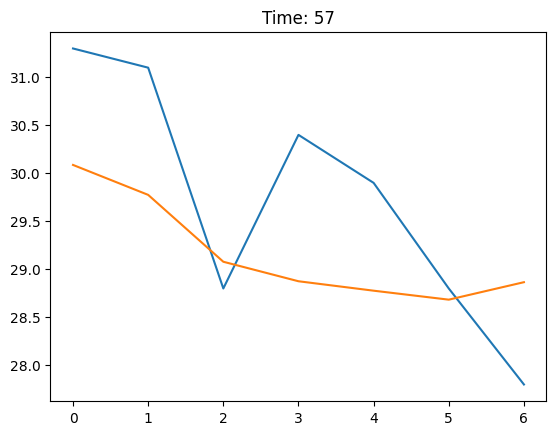

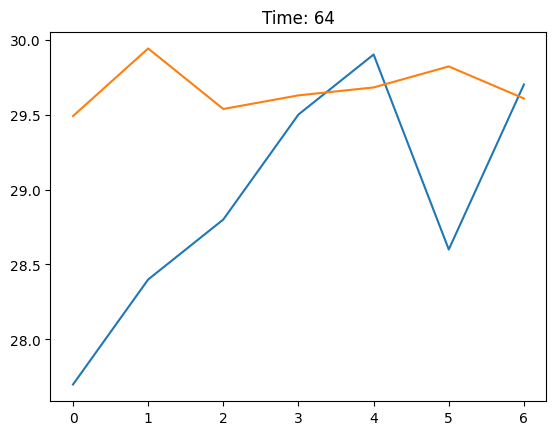

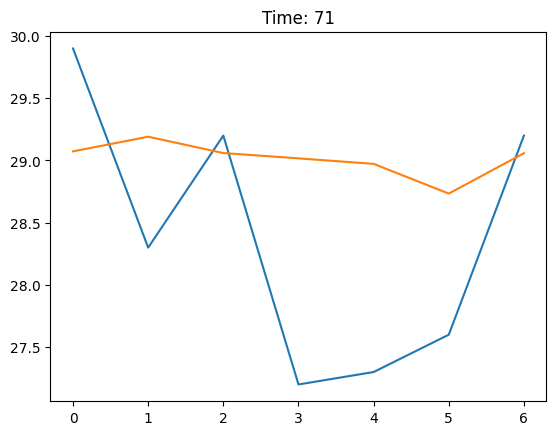

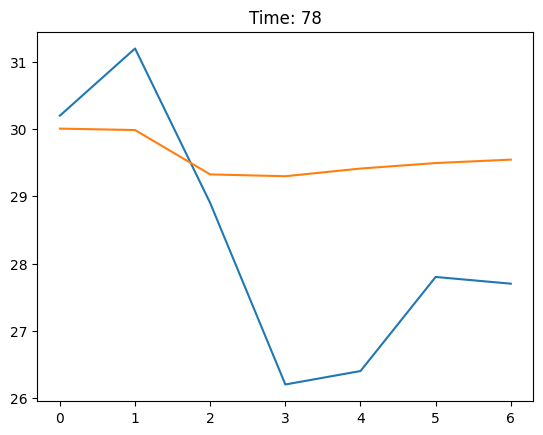

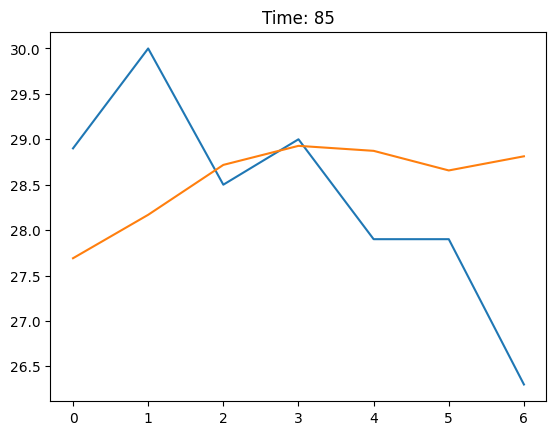

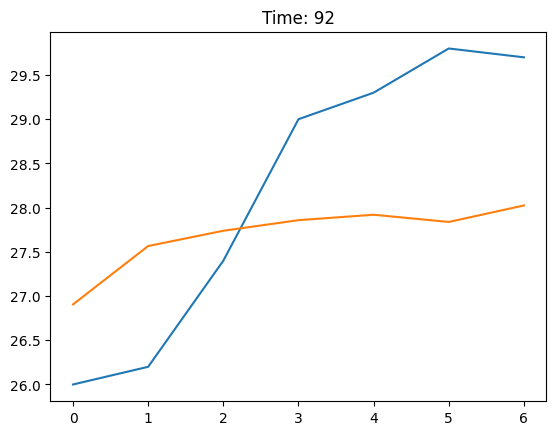

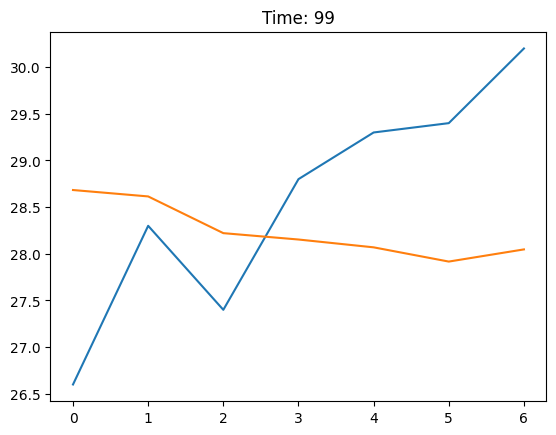

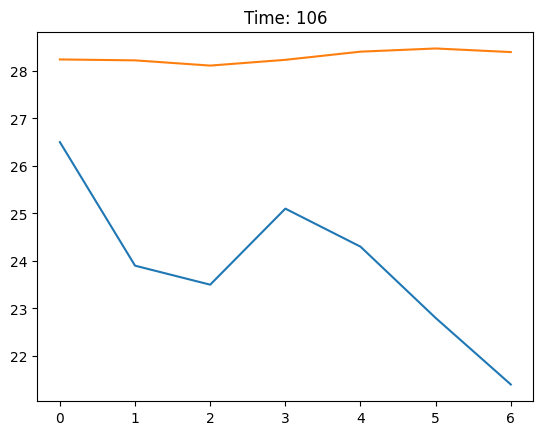

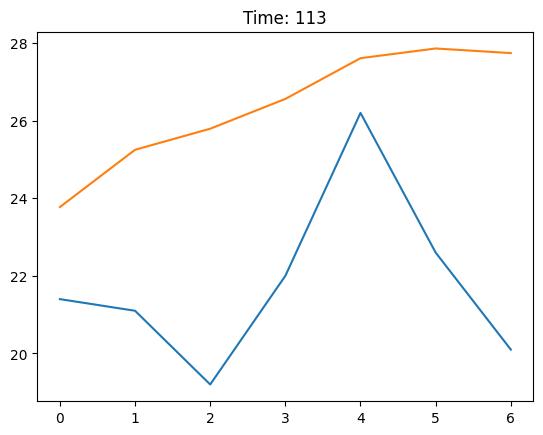

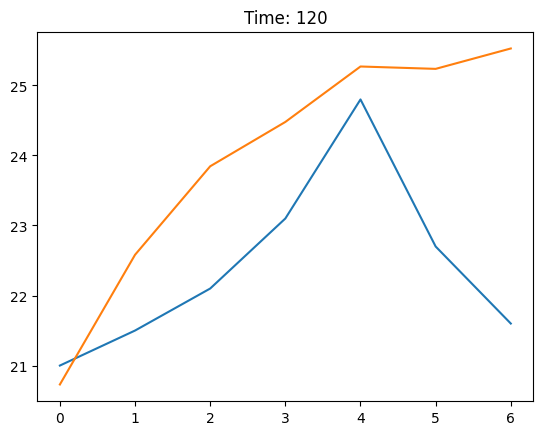

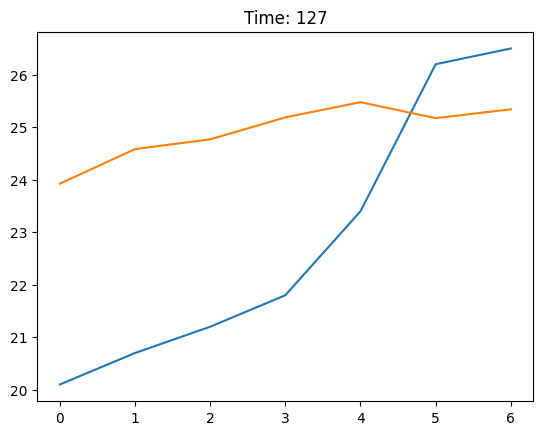

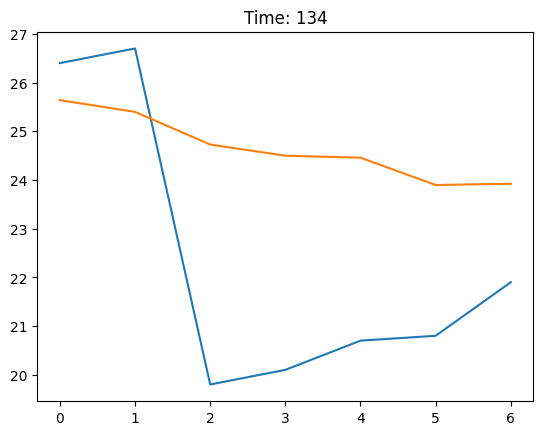

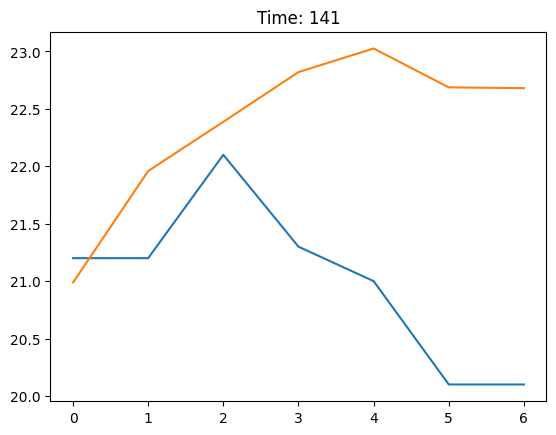

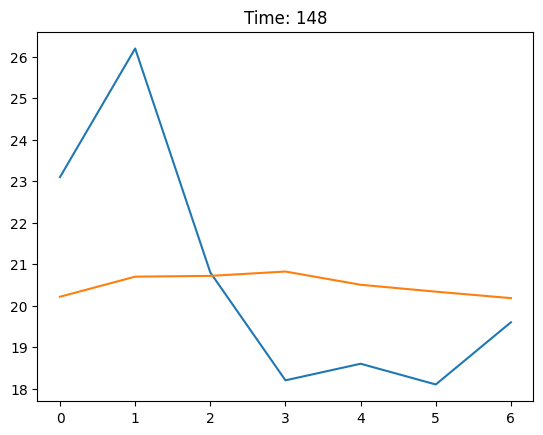

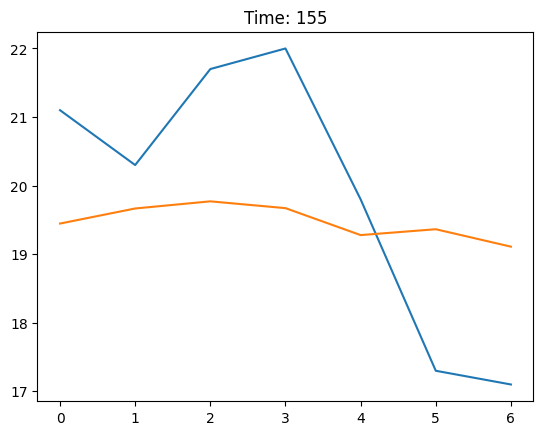

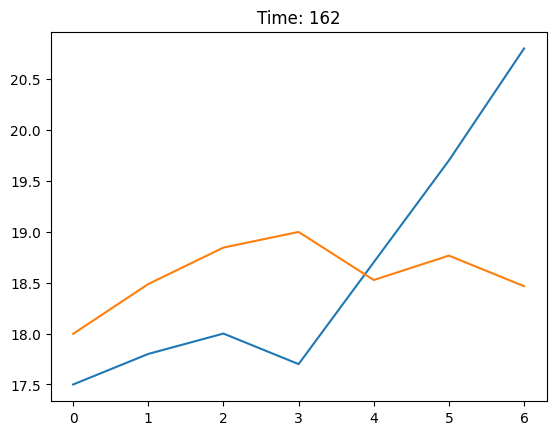

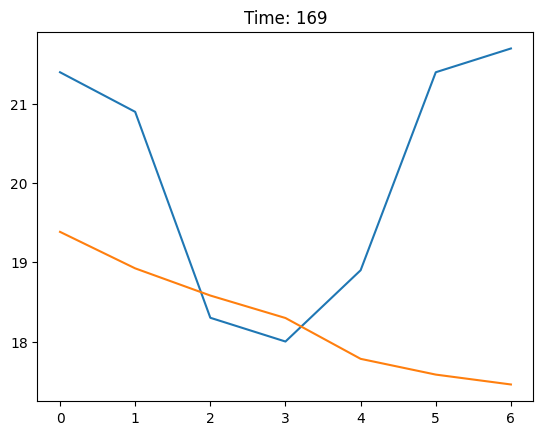

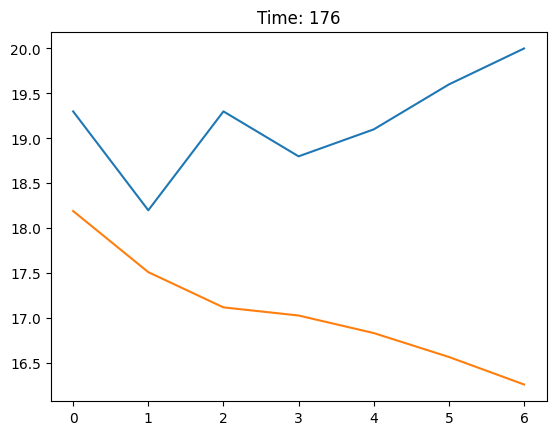

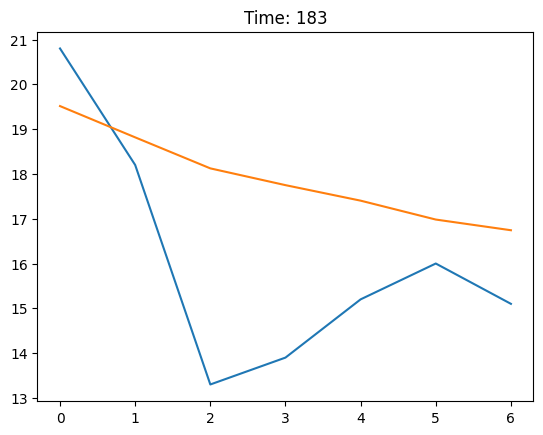

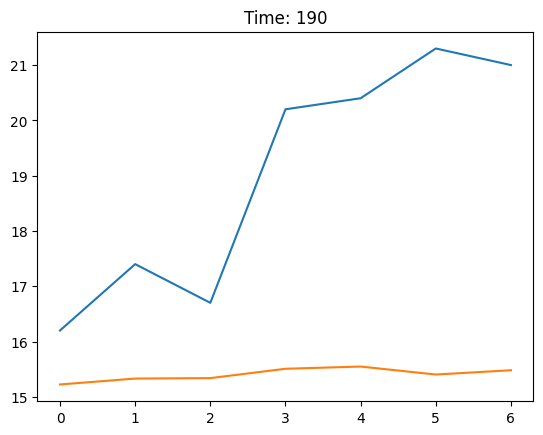

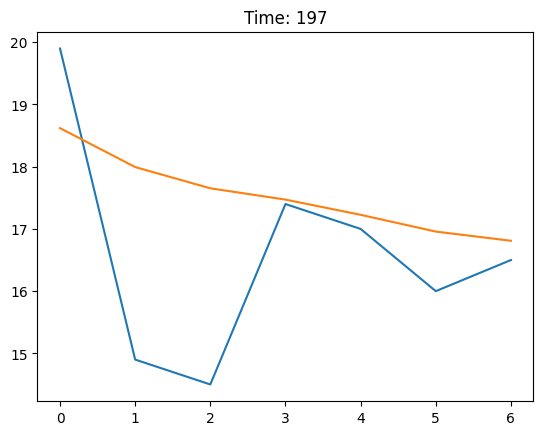

In [42]:
predict = model_recall.predict(X_test_norm)
feature = 0
predict_unnorm = unnormalize(predict, y_train.mean(), y_train.std())
y_test_unnorm = unnormalize(y_test_norm, y_train.mean(), y_train.std())
for i in range(7):
    print('Day: ', i+1)
    print('MAE: ', mean_absolute_error(y_test_unnorm[:,i,feature], predict_unnorm[:,i,feature]))
    print('MSE: ', mean_squared_error(y_test_unnorm[:,i,feature], predict_unnorm[:,i,feature]))
    print('CORR: ', np.corrcoef(y_test_unnorm[:,i,feature], predict_unnorm[:,i,feature])[0,1])
for i in range(7):
    plt.title('Day: ' + str(i+1))
    plt.plot(y_test_unnorm[:,i,feature])
    plt.plot(predict_unnorm[:,i,feature])
    plt.legend(['True', 'Predict'])
    plt.show()
for i in range(0, 200, 7):
    plt.title('Time: ' + str(i+1))
    plt.plot(y_test_unnorm[i,:,feature])
    plt.plot(predict_unnorm[i,:,feature])
    plt.show()
    

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Day:  1
MAE:  1.3200931738571264
MSE:  2.9944188617498853
CORR:  0.9440760708713581
Day:  2
MAE:  1.8616499952312162
MSE:  5.865879872906239
CORR:  0.8933207378623046
Day:  3
MAE:  2.080636138586452
MSE:  7.069395510079259
CORR:  0.8627883793001669
Day:  4
MAE:  2.178124104823201
MSE:  7.626521770683228
CORR:  0.8466321885797321
Day:  5
MAE:  2.3640130930791408
MSE:  9.030768526628941
CORR:  0.8317696381565003
Day:  6
MAE:  2.3539406288262317
MSE:  8.933581783082342
CORR:  0.8260062239835475
Day:  7
MAE:  2.3565068852566746
MSE:  9.003172630568642
CORR:  0.8224517386412187
Day:  8
MAE:  2.446172292392146
MSE:  9.61203276515773
CORR:  0.8136531358592547
Day:  9
MAE:  2.5459079565291267
MSE:  10.516593099357928
CORR:  0.8114505896986448
Day:  10
MAE:  2.452378145304406
MSE:  9.578242348755852
CORR:  0.8121335366350768
Day:  11
MAE:  2.658905454433762
MSE:  11.384172524066507
CORR:  0.8096647483615422
Day:  12
MAE:  2.715023728735246
MSE:  11.804504

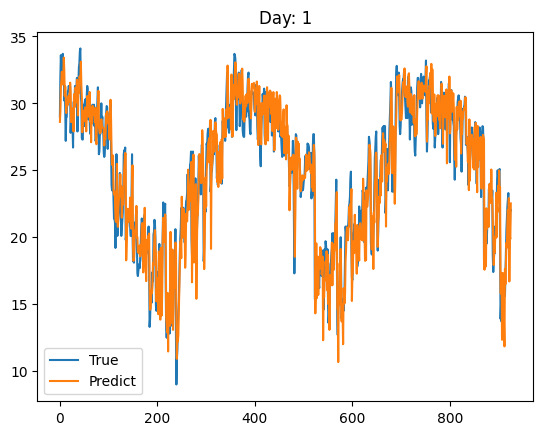

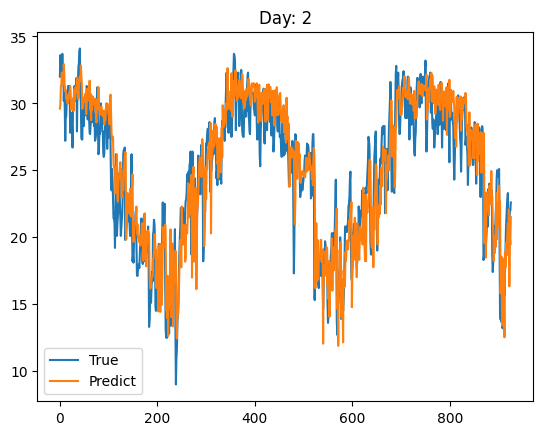

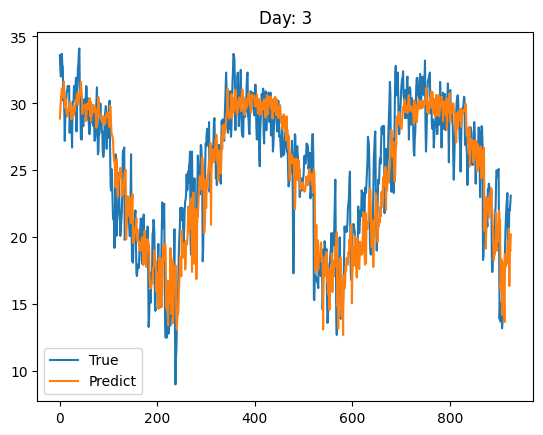

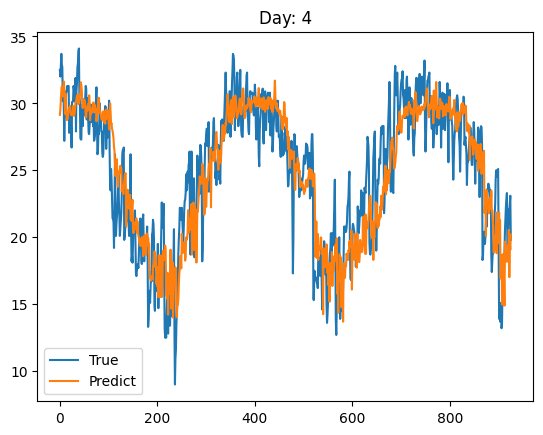

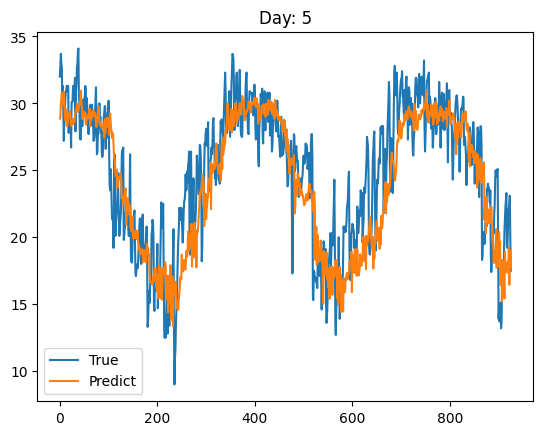

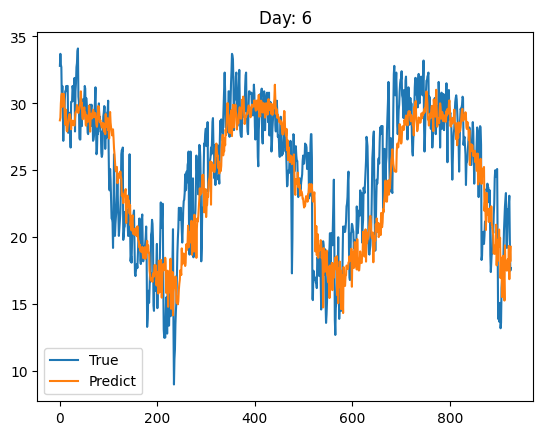

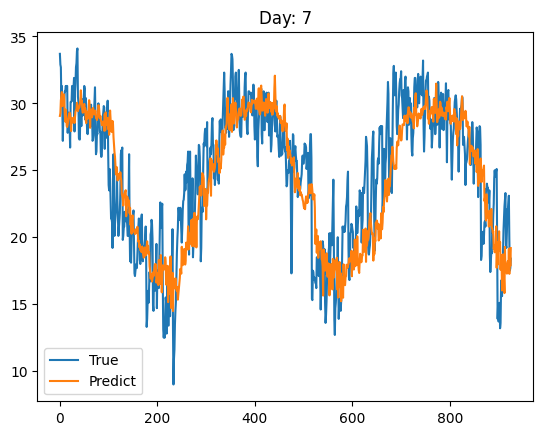

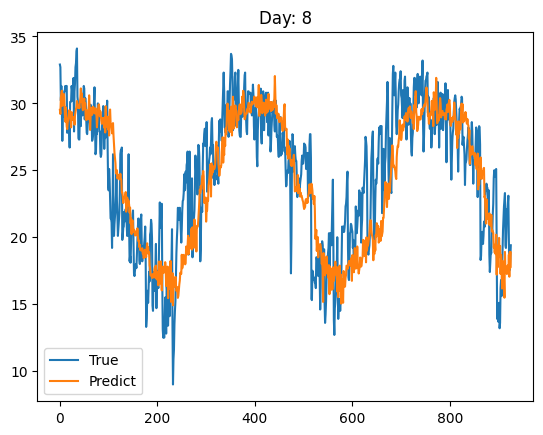

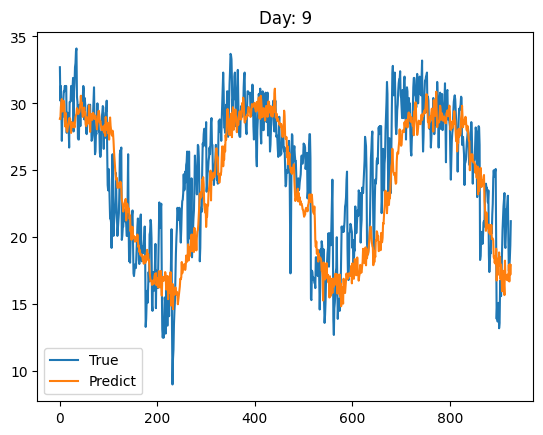

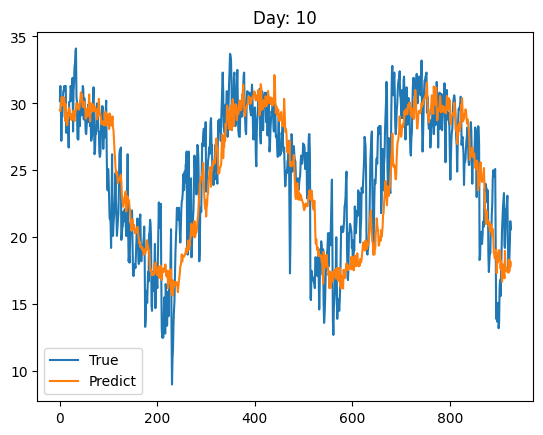

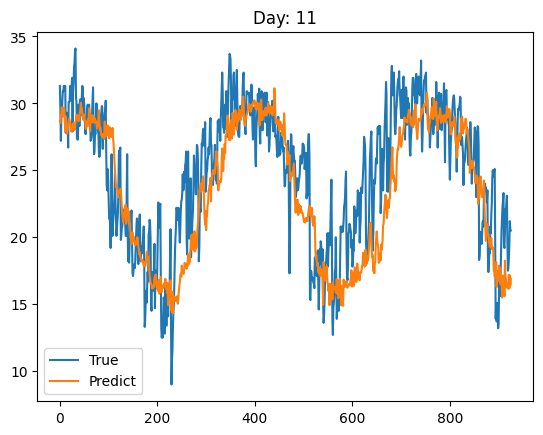

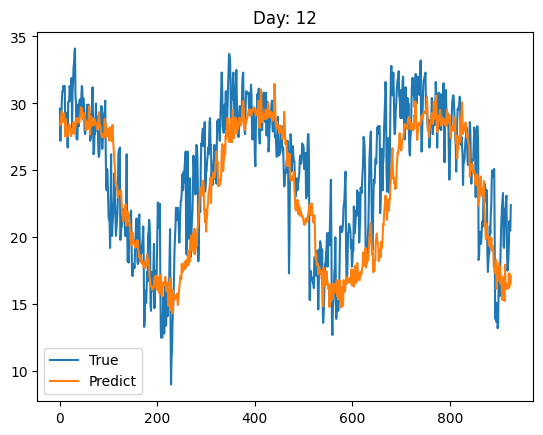

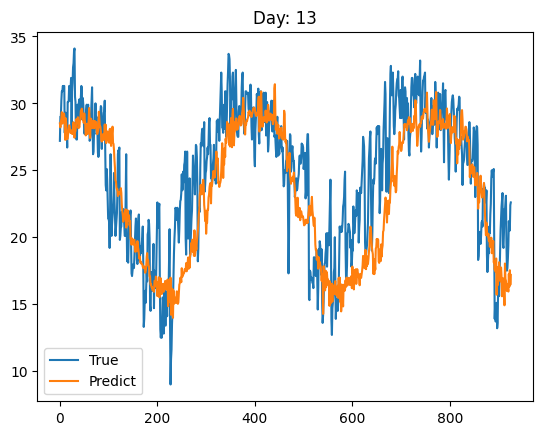

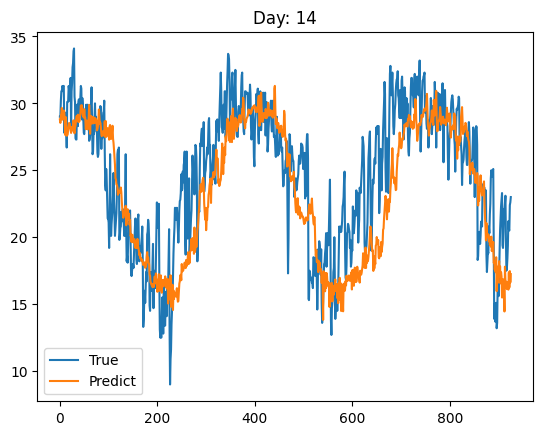

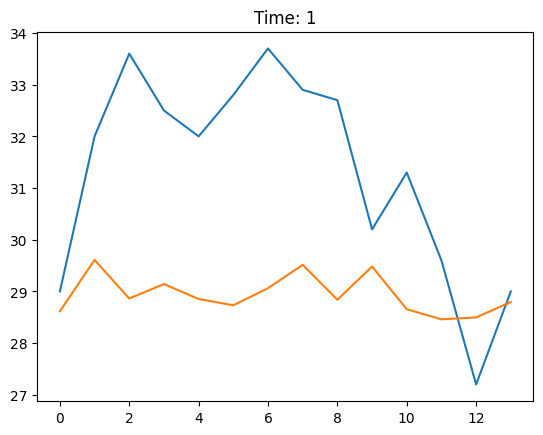

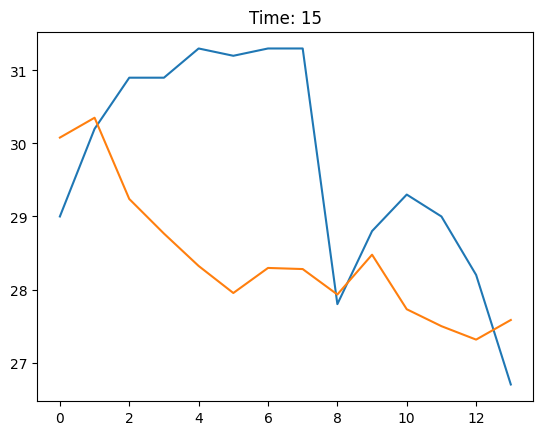

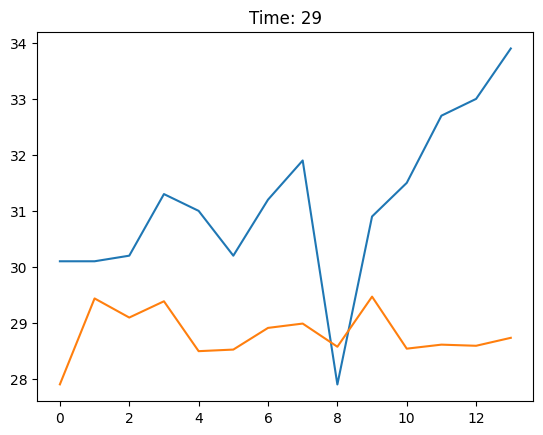

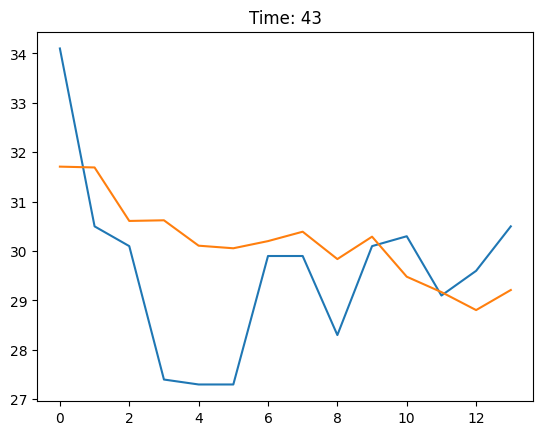

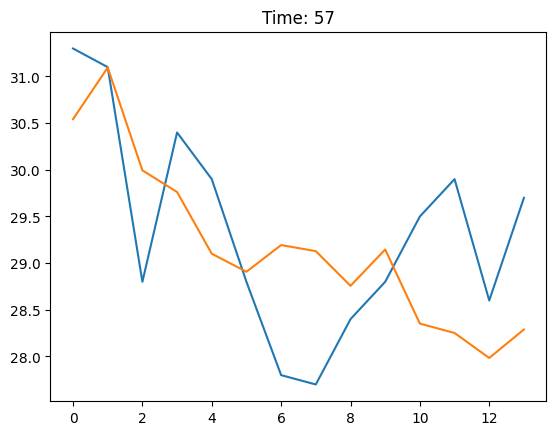

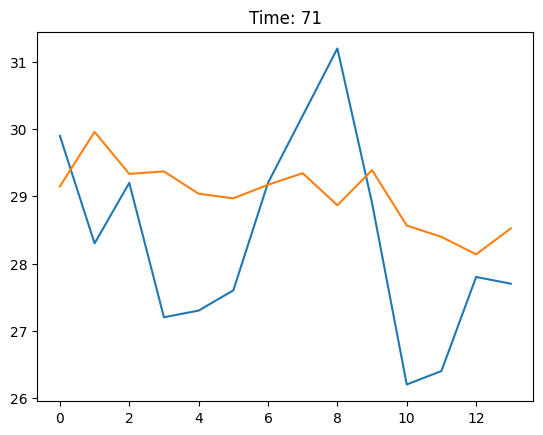

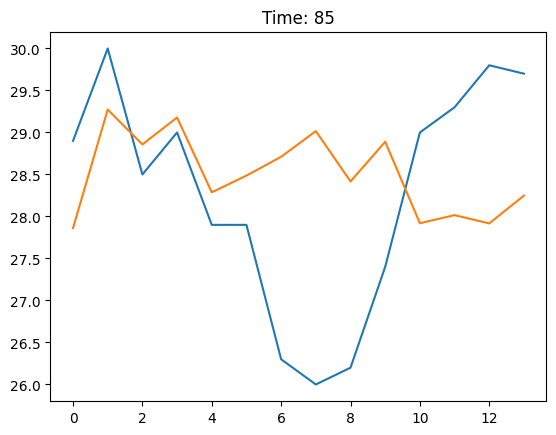

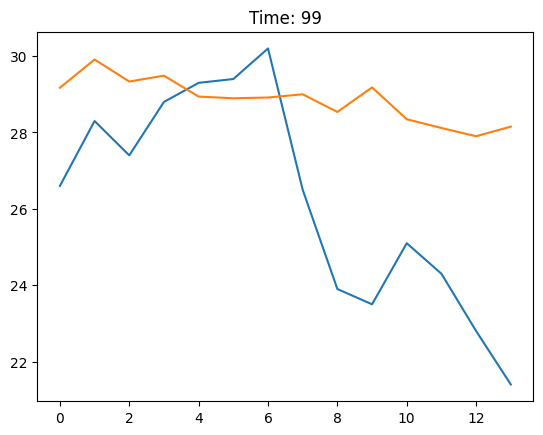

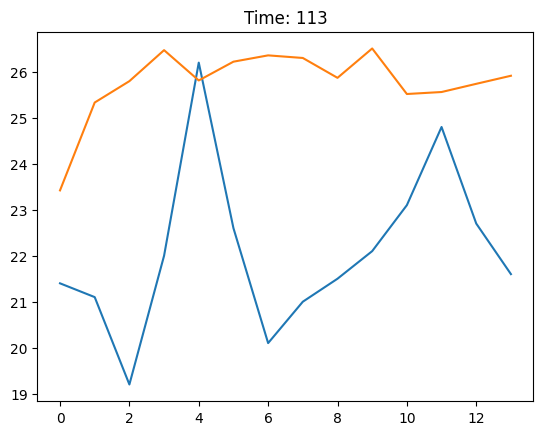

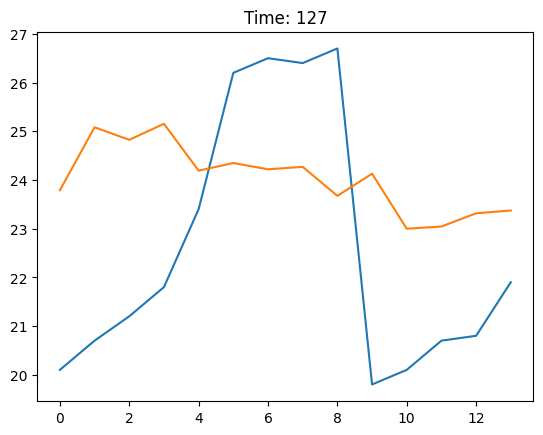

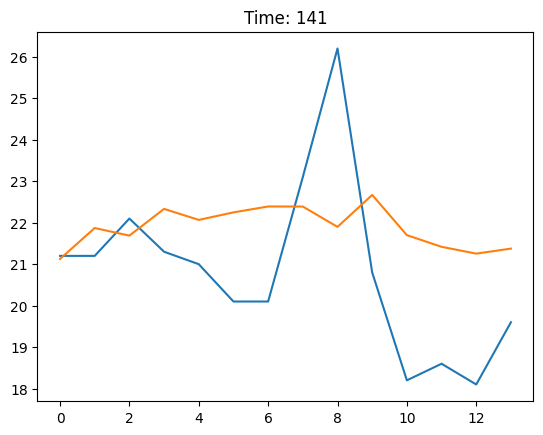

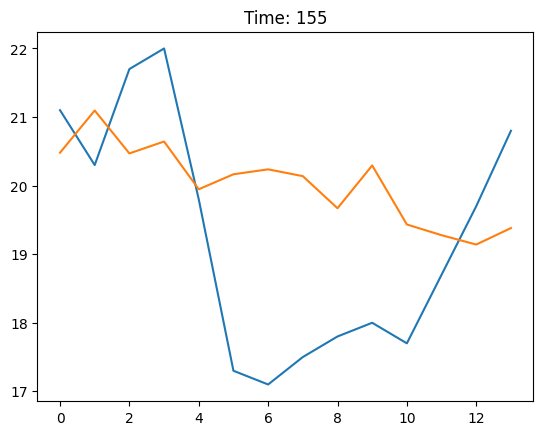

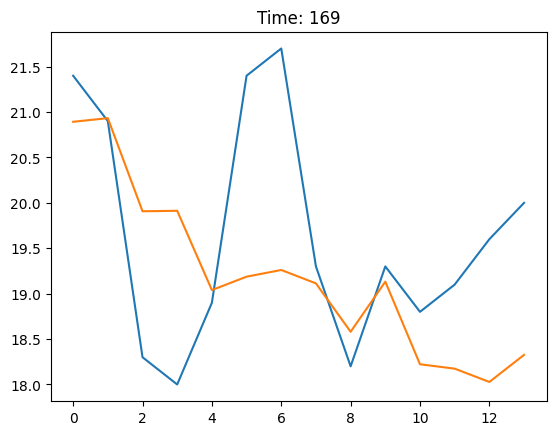

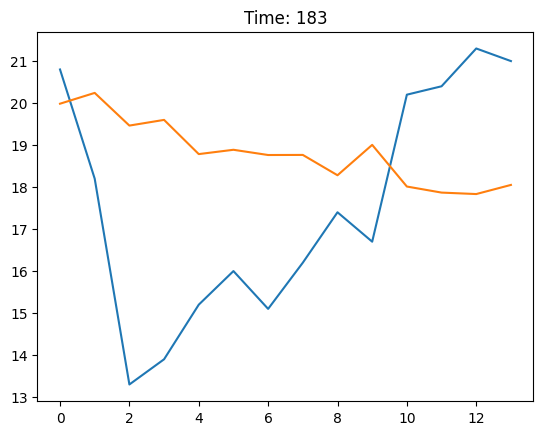

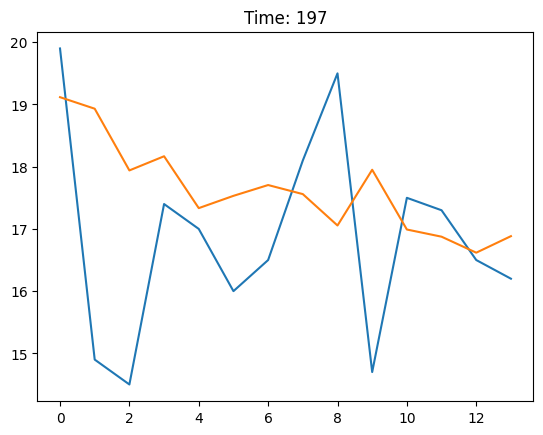

In [54]:
predict = model.predict(X_test_norm)
predict_unnorm = unnormalize(predict, y_train.mean(), y_train.std())
y_test_unnorm = unnormalize(y_test_norm, y_train.mean(), y_train.std())
for i in range(14):
    print('Day: ', i+1)
    print('MAE: ', mean_absolute_error(y_test_unnorm[:,i,0], predict_unnorm[:,i,0]))
    print('MSE: ', mean_squared_error(y_test_unnorm[:,i,0], predict_unnorm[:,i,0]))
    print('CORR: ', np.corrcoef(y_test_unnorm[:,i,0], predict_unnorm[:,i,0])[0,1])
for i in range(14):
    plt.title('Day: ' + str(i+1))
    plt.plot(y_test_unnorm[:,i,0])
    plt.plot(predict_unnorm[:,i,0])
    plt.legend(['True', 'Predict'])
    plt.show()
for i in range(0, 200, 14):
    plt.title('Time: ' + str(i+1))
    plt.plot(y_test_unnorm[i,:,0])
    plt.plot(predict_unnorm[i,:,0])
    plt.show()